In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from tqdm import tqdm

import matplotlib.pyplot as plt

from models import GPT
from tokenizers import Tokenizer

from utils import BatchLoader, estimate_loss, train_loop

# hyperparameters
batch_size = 16  # number of independent sequences that'll be processed in parallel
block_size = 128  # maximum context length for the preds
max_iters = 1000
eval_interval = 200
learning_rate = 3e-4
device = "mps" if torch.backends.mps.is_available() else "cpu"
eval_iters = 200
n_embd = 256
n_head = 4
n_blocks = 4
dropout = 0.2
# --------------

torch.manual_seed(1337)

# data preparation
text = open("dataset/tinyshakespeare.txt", "r").read()
# set up the vocabulary
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
tokenizer = Tokenizer(chars)

data = torch.tensor(tokenizer.encode(text), dtype=torch.long)

n = int(0.9 * len(data))  # first 90% will be the training set
n1 = int(0.98 * len(data))  # 90-98% will be the validation set and the last 2% will be the calibration set for the paper

train_data = data[:n]
val_data = data[n:n1]
calibrate_data = data[n1:]

train_loader = BatchLoader(train_data, block_size, batch_size, device, name="train")
val_loader = BatchLoader(val_data, block_size, batch_size, device, name="val")
calibration_loader = BatchLoader(calibrate_data, block_size, batch_size, device, name="calibrate")


UNIFORM BASELINE:  4.174387454986572


step 800: train loss 2.0373, val loss 2.0801: 100%|██████████| 1000/1000 [03:49<00:00,  4.36it/s]


training is done!


Appy ecreace flesh, quince bouboal ford?
Habr And sirear his spown Poghe so inge jit shay.

ARENTEO:
Thave in you ye shaven dou mesoel!
Nothe briffor to I fulllf I theeipouldss;
Wind swird fre piodly besewel've is lod;
An ing, hiplow to wat Lrd mers, hand be not hensy?
Whare to blikne, fore, ups me thons!
Hing sistris have wencthisus,
Ser son: the For 'tlevembabe;
Tor ben alinss me cewids reme
jr kenind mu; ast hip aght nor. hich nackis me, thay
Phey Karrd sonfor kim pate ard.
You moneto wour s


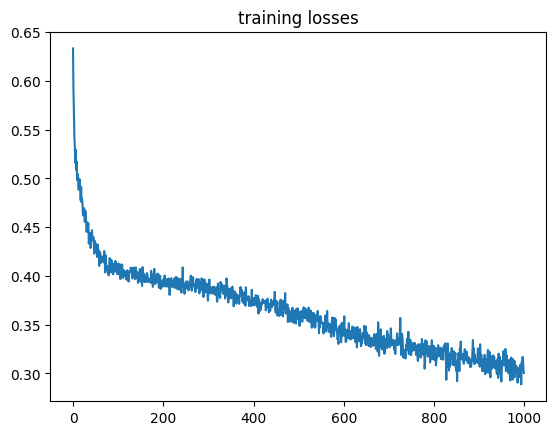

In [69]:
model = GPT(vocab_size, block_size, n_embd, n_head, n_blocks, device, dropout)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

training_losses = train_loop(model, optimizer, vocab_size, train_loader, [train_loader, val_loader], max_iters, eval_interval, eval_iters)

print("training is done!")

plt.title("training losses")
plt.plot(training_losses)
plt.savefig("training_losses.png")

idx = torch.zeros((1, 1), dtype=torch.long, device=device)
print(tokenizer.decode(model.generate(idx, max_new_tokens=500)[0].tolist()))

In [70]:
from utils import save

model_params = {
    "vocab_size": vocab_size,
    "block_size": block_size,
    "n_embd": n_embd,
    "n_head": n_head,
    "n_blocks": n_blocks,
    "dropout": dropout,
    "device": device
}

save(model, tokenizer, model_params, "model")

In [2]:
from utils import load

In [51]:
loaded_model, tokenizer = load(GPT, "model")
loaded_model.to(device);

/Users/alperiox/Desktop/coding/paper-implts/Compact_Language_Models_240714679/utils.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(sav

In [52]:
def attn_head_importance_hook(module, ins, outs) -> None: # TODO: does the importance calculation returns the correct values for each head? 
    """ calculates the multi-head-attention layer's importance per head """

    # outs.shape = (B, T, E) where B: batch_size, T: num tokens, E: embedding size
    # the importance is calculated as summing the L2 norm of the attn outputs on B and T dimensions
    outs_flat = outs.view(-1, outs.shape[-1]) # (b,t,e) -> (b*t, e)
    importance = torch.linalg.vector_norm(outs_flat.detach().cpu(), ord=2, dim=-1).sum()

    module.calculated_importance = importance
    
    # print(outs_flat.shape)
    # print("module:", module.__class__.__name__, end=" ")
    # print("importance:", importance)
    print(f"{module.__class__.__name__} importance: {importance.shape}")

def neuron_importance_hook(module, ins, outs) -> None:
    """ calculates the neuron importance for the given layer """ 
    
    # for each neuron in the ffwd layer, we will simply sum up the output columns
    # as they're the activations of individual neurons
    # calculate the importances
    # importance = outs.detach().sum()
    importance = outs.detach().cpu().sum(dim=(0,1))
    print(f"{module.__class__.__name__} importance.shape: {importance.shape}")

    module.calculated_importance = importance

def embedding_importance_hook(module, ins, outs) -> None:
    # the first block's first processing layer will be the 
    # layer norm,
    # so we'll just sum up the layer norm outputs after getting them
   # calculate the importances
    importance = outs.detach().sum(dim=(0,1))
    # print("importance.shape:", importance.shape)
    # print("n_embd: ", outs.size(-1))
    # print("module:", module.__class__.__name__)
    # print("outs.shape:", outs.shape) # probably (B, T, E)
 
    module.calculated_importance = importance

    print(f"{module.__class__.__name__} importance.shape: {importance.shape}")

def block_importance_hook(module, ins, outs) -> None:
    
    in_vectors = ins[0].detach()  # (B, T, E)
    out_vectors = outs.detach()   # (B, T, E)
    
    # Calculate cosine similarity for each sample and time step
    dot_product = torch.sum(in_vectors * out_vectors, dim=-1)  # (B, T)
    in_norm = torch.norm(in_vectors, p=2, dim=-1)  # (B, T)
    out_norm = torch.norm(out_vectors, p=2, dim=-1)  # (B, T)
    
    cosine_sim = dot_product / (in_norm * out_norm + 1e-8)  # (B, T)
    
    # Calculate BI by taking the expectation (mean) and subtracting from 1
    block_importance = 1 - torch.mean(cosine_sim)
    
    # print("Block Importance:", block_importance.item())
    # print("module:", module.__class__.__name__)
    # print("outs.shape:", outs.shape)  # (B, T, E)
 
    module.calculated_importance = block_importance

    print(f"{module.__class__.__name__} importance.shape: {block_importance.shape}")

In [53]:
# set up the initial hooks for all the corresponding layers
from models import Block, GPT

def delete_importance_attr(layer: nn.Module):
    if hasattr(layer, "calculated_importance"):
        del layer.calculated_importance

def remove_all_forward_hooks(model: GPT):
    if not isinstance(model, GPT):
        raise NotImplementedError("Only GPT models are supported for now")
    
    for module in model.modules():
        if isinstance(module, Block):
            for head in module.sa.heads:
                head._forward_hooks.clear()
                delete_importance_attr(head)

            module.ffwd._forward_hooks.clear()
            module.ln1._forward_hooks.clear()
            module.sa._forward_hooks.clear()

            delete_importance_attr(module.ffwd)
            delete_importance_attr(module.ln1)
            delete_importance_attr(module.sa)

def register_all_forward_hooks(model: GPT):
    if not isinstance(model, GPT):
        raise NotImplementedError("Only GPT models are supported for now")

    num_blocks = 0
    for module in loaded_model.modules():
        if isinstance(module, Block):
            num_blocks += 1
            for head in module.sa.heads:
                head.register_forward_hook(attn_head_importance_hook)
            module.ffwd.register_forward_hook(neuron_importance_hook)
            if num_blocks == 1:
                module.ln1.register_forward_hook(embedding_importance_hook)
            module.register_forward_hook(block_importance_hook)

In [54]:
# TODO: PRUNING AND TRIMMING
    # TODO: simple pruning strategy for pruning and trimming the models based on the given paper.
    # TODO: implement a lightweight training pipeline using the calibration dataset and stabilize the rankings
# TODO: implement knowledge distillation-based full retraining strategy based on the findings in the paper
    # 5. Retrain exclusively with distillation loss using KLD instead of conventional training.
    # 6. Use (logit+intermediate state+embedding) distillation when depth is reduced significantly.
    # 7. Use logit-only distillation when depth isn’t reduced significantly.
    # 8. Prune a model closest to the target size.
    # 9. Perform lightweight retraining to stabilize

In [55]:
remove_all_forward_hooks(loaded_model)
register_all_forward_hooks(loaded_model)

In [66]:
# neuron and head pruning? 

# start with neuron pruning

def prune_neurons(model, ratio=0.2) -> None:
    # goal: trim the MLP layer weights
    # 1 - argsort the importances of the `ffwd` layers defined in the model
    # 2 - remove the weights with respect to the given ratio

    for module in model.modules():
        if isinstance(module, Block):
            importances = module.ffwd.calculated_importance
            num_neurons = int(ratio * importances.size(0))
            idx = importances.argsort(descending=True)[:num_neurons]
            # reinitialize the weights along with the layer
            dense1 = module.ffwd.net[0]
            dense2 = module.ffwd.net[2]

            dense1.weight.data = dense1.weight.data[idx, :]
            dense1.bias.data = dense1.bias.data[idx]

            dense2.weight.data = dense2.weight.data[idx, :]
            dense2.bias.data = dense2.bias.data[idx]


def prune_heads(model, ratio=0.2) -> None:
    # goal: trim the attention heads' layer weights using the same approach as the `prune_neurons`
    pass


def prune_embeddings(model, ratio=0.2) -> None:
    # goal: trim the embedding dimension of the weight matrices in MLP, MHA, and LayerNorm layers.
    # TODO: check how embedding importance is calculated!
    pass

In [69]:
def reinit_models():
    loaded_model, tokenizer = load(GPT, "model")
    loaded_model.to(device);

    remove_all_forward_hooks(loaded_model)
    register_all_forward_hooks(loaded_model)

    return loaded_model, tokenizer

model, tokenizer = reinit_models()

In [68]:
prune_neurons(loaded_model, 0.2)

In [70]:
x = torch.randn(3, 8, dtype=torch.long, device=device)

loaded_model(x)

LayerNorm importance.shape: torch.Size([256])
LayerNorm importance.shape: torch.Size([256])
LayerNorm importance.shape: torch.Size([256])
LayerNorm importance.shape: torch.Size([256])
LayerNorm importance.shape: torch.Size([256])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])
Head importance: torch.Size([])


RuntimeError: linear(): input and weight.T shapes cannot be multiplied (8x256 and 51x51)

In [59]:
loaded_model

GPT(
  (token_embedding_table): Embedding(65, 256)
  (position_embedding_table): Embedding(128, 256)
  (blocks): Sequential(
    (0): Block(
      (sa): MultiHeadAttentionConcat(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (key): Linear(in_features=256, out_features=64, bias=False)
            (query): Linear(in_features=256, out_features=64, bias=False)
            (value): Linear(in_features=256, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ffwd): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=1024, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1024, out_features=256, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
